In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import  numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

df_tracks = pd.read_csv('MyData/output/all_tracks.csv').dropna()
df_tracks = df_tracks[df_tracks["count"] >= 5 ]

Features (9): danceability, acousticness, energy, instrumentalness, liveness,   valence, loudness, speechiness, tempo

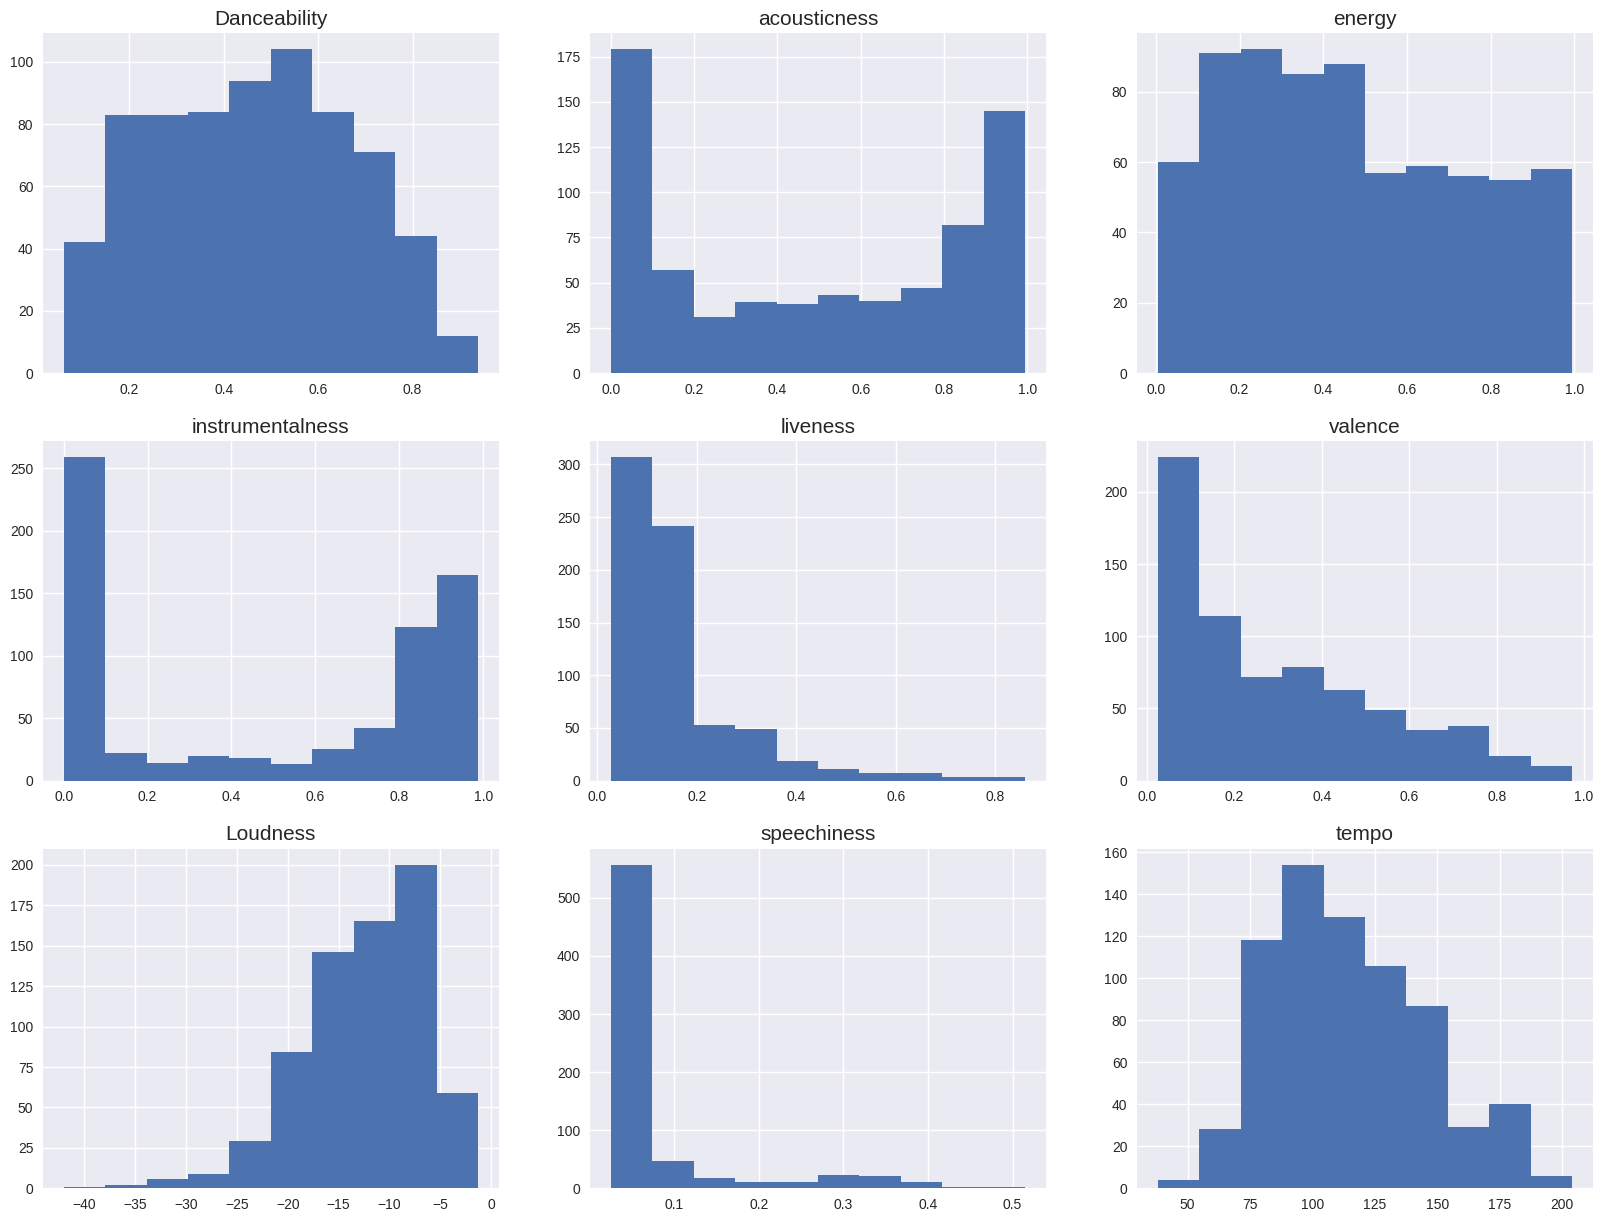

In [2]:
fig,axes = plt.subplots(3,3,figsize=(20,15))

axes[0,0].hist(df_tracks['danceability'])
axes[0,0].set_title('Danceability',fontsize=15)
axes[0,1].hist(df_tracks['acousticness'])
axes[0,1].set_title('acousticness',fontsize=15)
axes[0,2].hist(df_tracks['energy'])
axes[0,2].set_title('energy',fontsize=15)
axes[1,0].hist(df_tracks['instrumentalness'])
axes[1,0].set_title('instrumentalness',fontsize=15)
axes[1,1].hist(df_tracks['liveness'])
axes[1,1].set_title('liveness',fontsize=15)
axes[1,2].hist(df_tracks['valence'])
axes[1,2].set_title('valence',fontsize=15)
axes[2,0].hist(df_tracks['loudness'])
axes[2,0].set_title('Loudness',fontsize=15)
axes[2,1].hist(df_tracks['speechiness'])
axes[2,1].set_title('speechiness',fontsize=15)
axes[2,2].hist(df_tracks['tempo'])
axes[2,2].set_title('tempo',fontsize=15)
plt.show()

### TODO PCA 

In [3]:
df_pca = df_tracks[["danceability", "energy",  "speechiness", "liveness", "valence", "loudness","acousticness", "instrumentalness", "tempo"]].dropna()
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(df_pca)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_features)
print(pca.components_)
print(pca.explained_variance_)

[[-0.31911717 -0.43722103 -0.27462771 -0.1344419  -0.38518597 -0.43122906
   0.37458761  0.36290739 -0.0846322 ]
 [ 0.45331426 -0.2893938   0.52043829 -0.04745275  0.22315123 -0.21823589
   0.40752965 -0.11072738 -0.4023497 ]]
[3.88046025 1.22521918]


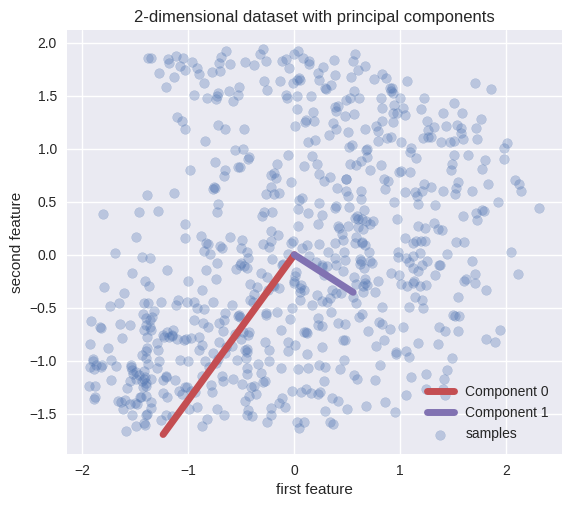

In [4]:
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

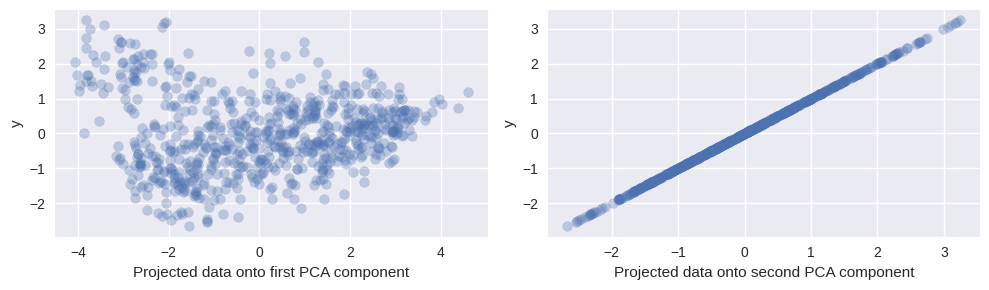

In [5]:
y = scaled_features.dot(pca.components_[1]) 

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(scaled_features.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel='Projected data onto first PCA component', ylabel='y')
axes[1].scatter(scaled_features.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel='Projected data onto second PCA component', ylabel='y')
plt.tight_layout()
plt.show()

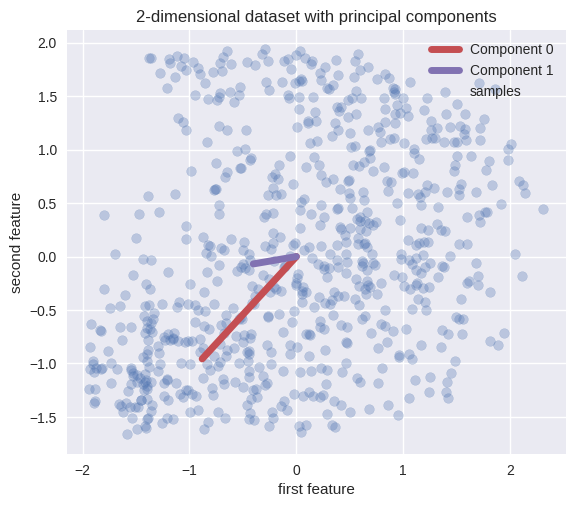

In [7]:
df_pca = df_tracks[["danceability", "energy","tempo"]].dropna()
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(df_pca)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_features)

plt.scatter(scaled_features[:, 0], scaled_features[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

In [6]:
# k-means with centered featuress
scaler = StandardScaler(with_mean=True, with_std=False)
centered_features = scaler.fit_transform(features)
kmeans = KMeans(init="k-means++",n_clusters=3,random_state=15).fit(centered_features)
df_tracks['kmeans'] = kmeans.labels_


NameError: name 'features' is not defined

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

x = df_tracks['energy']
y = df_tracks['danceability']
z = df_tracks['tempo']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df_tracks['kmeans'],s=40,cmap=cmhot, edgecolor="black")
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('tempo',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered with centered features")
plt.show()

In [ ]:
# k-means with scaled featuress
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(features)
kmeans = KMeans(init="k-means++",n_clusters=3,random_state=15).fit(scaled_features)
df_tracks['kmeans'] = kmeans.labels_
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

x = df_tracks['energy']
y = df_tracks['danceability']
z = df_tracks['tempo']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df_tracks['kmeans'],s=40,cmap=cmhot, edgecolor="black")
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('tempo',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered with scaled features (mean + standard deviation)")
plt.show()